In [1]:
using Plots
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using Random

In [2]:
t0 = 0.0
tend = 5.0
N = 200

rand_array = randperm(201)
ts = range(t0, tend, length=N+1)
train_x = sort([ts[i] for i in rand_array[1:Int(N*0.8)]])
train_y = 2*exp.(-train_x./0.4)
test_x = sort([ts[i] for i in rand_array[Int(N*0.8+1):end]])
test_y = 2*exp.(-test_x./0.4)

41-element Vector{Float64}:
 2.0
 1.6580582363608007
 0.691181505153949
 0.5382926974583677
 0.5056791916094929
 0.4192227743021956
 0.34754788690089033
 0.28812731820290655
 0.2706705664732254
 0.1448795140685029
 0.12010933579061589
 0.11283227900755474
 0.07754841566344402
 ⋮
 0.0002468196081733591
 0.0001922233041227894
 0.00018057708287011581
 0.00013211301605736963
 2.295779978142114e-5
 1.6796285126315502e-5
 1.5778649654400446e-5
 1.482266959890114e-5
 1.3924609446975891e-5
 1.1543906690832895e-5
 9.570234784258018e-6
 8.990403570523905e-6

In [3]:
function neural_network(data_dim)
    fc = FastChain(FastDense(data_dim, 8, swish),
                  FastDense(8, 4, swish),
                  FastDense(4, data_dim))
end

nn = neural_network(1)
theta = initial_params(nn)

predict(t, p) = nn(t', p)'

loss(p) = begin
  yhat = predict(train_x, p)
  l = Flux.mse(yhat, train_y)
end

learning_rate=1e-2
opt = ADAMW(learning_rate)
epochs = 2000

loss_array = []

function cb_train(theta, loss)
    #println("Loss: ", loss)
    append!(loss_array, loss)
    false
end

@time res_train = DiffEqFlux.sciml_train(
    loss, theta, opt,
    maxiters = epochs,
    cb = cb_train)

predicted_y = predict(test_x, res_train.minimizer)

 50.191828 seconds (104.19 M allocations: 6.974 GiB, 3.87% gc time, 98.78% compilation time)


41×1 adjoint(::Matrix{Float64}) with eltype Float64:
  1.782212737974962
  1.5988760455734035
  0.6981063461497237
  0.5199464006724059
  0.4826090116221249
  0.38658995338458413
  0.3120188786772418
  0.2552218677975114
  0.23959258101041586
  0.14319502428305664
  0.12700529845058395
  0.12227304790849214
  0.0980479546885662
  ⋮
  0.012226880391419281
  0.014544395159928558
  0.015018162116776645
  0.01667147083946563
 -0.0016123204625302368
 -0.010370568312450312
 -0.012327006890853975
 -0.014351410557222666
 -0.0164436045367643
 -0.023124859223995986
 -0.030407946820117715
 -0.03296806303100597

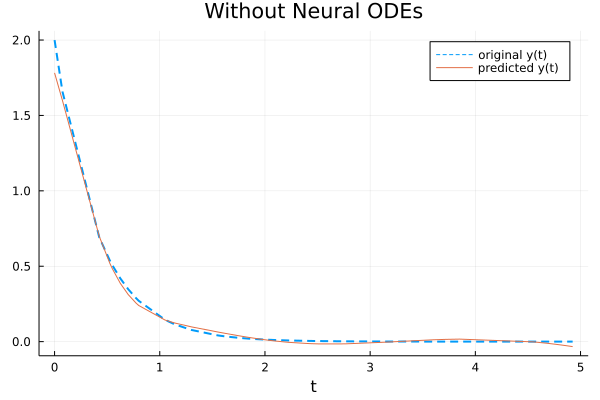

In [4]:
plot(test_x, test_y, linewidth=2, ls=:dash,
    title="Without Neural ODEs",
    xaxis="t",
    label="original y(t)",
    legend=:topright)
plot!(
    test_x,
    predicted_y,
    linewidth=1,
    label="predicted y(t)")

In [11]:
function neural_ode(data_dim; saveat = train_x)
    fc = FastChain(FastDense(data_dim, 64, swish),
                  FastDense(64, 32, swish),
                  FastDense(32, data_dim))

    n_ode = NeuralODE(
            fc,
            (minimum(train_x), maximum(train_x)),
            Tsit5(),
            saveat = saveat,
            abstol = 1e-2, reltol = 1e-2)
end

n_ode = neural_ode(1)
theta = n_ode.p

predict(p) = n_ode(train_y[1:1], p)'

loss(p) = begin
  yhat = predict(p)
  l = Flux.mse(yhat, train_y)
end

learning_rate=1e-2
opt = ADAMW(learning_rate)
epochs = 100

loss_array2 = []

function cb_train(theta, loss)
    #println("Loss: ", loss)
    append!(loss_array2, loss)
    false
end

@time res_train_ODE = DiffEqFlux.sciml_train(
    loss, theta, opt,
    maxiters = epochs,
    cb = cb_train)

predicted_y_ODE = predict(test_x, res_train_ODE.minimizer)

 15.559054 seconds (24.27 M allocations: 22.200 GiB, 23.13% gc time, 1.65% compilation time)


41×1 adjoint(::Matrix{Float64}) with eltype Float64:
 -0.4132100614728943
 -0.41096484755707485
 -0.40067877864013357
 -0.39779931793394363
 -0.39708366051881416
 -0.3949468596066115
 -0.3928254047559424
 -0.3907194031005091
 -0.39002085384490676
 -0.3831311047997739
 -0.3810983805646483
 -0.38042433616251137
 -0.37641727338756314
  ⋮
 -0.32296223768253807
 -0.3209696919827863
 -0.32047571073697306
 -0.318030629420204
 -0.305092446106084
 -0.3029148839564165
 -0.3024841483317921
 -0.3020550018069422
 -0.30162744307351375
 -0.3003542809116053
 -0.2990953641614674
 -0.2986788854247419

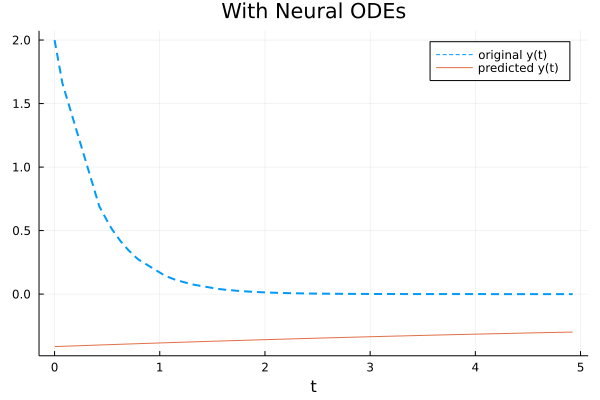

In [12]:
plot(test_x, test_y, linewidth=2, ls=:dash,
    title="With Neural ODEs",
    xaxis="t",
    label="original y(t)",
    legend=:topright)
plot!(
    test_x,
    predicted_y_ODE,
    linewidth=1,
    label="predicted y(t)")